In [1]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import cm
from scipy.integrate import quad
from scipy.optimize import curve_fit

%matplotlib widget

# Set up functions

In [2]:
#q   = 1.602e-19# C
#Ib  = 1E-3   # A Beam current
#Eb  = 2      # meV Beam energy
#eta = 1      # adsorbed fraction
#Ei  = 10   # e-h formation energy
#
#G0 = eta/Ei

## Collection efficiency 

All this is based on this paper `E B Yakimov et al 2020 J. Phys. D: Appl. Phys. 53 495108`

In [3]:
def Ic(Eb, tm, W, L, G0):
    """
    Returns Electron Beam Collection Efficiency 
    (EBIC) value as a function of electron beam energyepsabs = 1e-2, 
    for given parameters
    
    Parameters
    ----------
    Eb : float, array 
        Electron beam energy in meV
    tm : float
        Metal thickness in nm
    W : float
        Screen charge region thickness in nm
    L : float 
        Diffusion length in nm
    G0 : float 
        η/Ei portion of absorbed electrons (η)
        with e-h pair formation energy (Ei)
    
    Returns
    -------
    I : float, array
        Electron Beam Collection Efficiency in meV-1 
    """    
    
    def A(z, Eb):
        R = 7.34*Eb**(1.75) #[nm] for Eb in [keV]
        return np.piecewise(z, 
                            [     z < 0.22*R,    z >= 0.22*R],
                            [lambda z: 12.84, lambda z: 3.97])

    def h(z, Eb):
        R = 7.34*Eb**(1.75) #[nm] for Eb in [keV]
        return 1.603/R*np.exp(-A(z, Eb)*(z/R - 0.22)**2)
    
    def hexp(z, Eb):
        R = 7.34*Eb**(1.75) #[nm] for Eb in [keV]
        return 1.603/R*np.exp(-A(z, Eb)*(z/R - 0.22)**2)*np.exp(-(z-W)/L)

    
    I1 = np.asarray([quad(   h, tm,      W, args=(_Eb), 
                          epsabs = 1e-2, epsrel = 1e-2)[0] for _Eb in Eb])
    I2 = np.asarray([quad(hexp, tm, np.inf, args=(_Eb), 
                          epsabs = 1e-2, epsrel = 1e-2)[0] for _Eb in Eb])
    I  = (I1 + I2)
    I = I*G0
    return I

## Fit data

In [4]:
def fit_data(path, tm, W, speed = True, plot = True, error = False):
    """
    Computes optimal parameters for EBIC data 
    and returns fitted data
    
    
    Parameters
    ----------
    path : string
        Path to data file
    tm : float
      Initial guess value of metal thickness
    W : float
        Initial guess value of SCR
    
    Returns
    -------
    Eb : array
        Electron beam energies from data file in meV
    I : array
        Collection efficiencies for E from data file in meV-1
    Ic : array
        Fitted collection efficiencies for E and popt
    popt : [tm, W, L, G0]
        Optimal fitting parameters for Ic() func
        
    Other Parameters
    ----------------
    speed : bollean
        True for Elapsed time display
    plot : boolean
        True for plot fitted data
    error : boolean
        True for plot confidence intefval
    """
    
            
    def plot_data(Eb, I, popt, perr):
        """
        Plots experimental and fitted data
        """
        
        I_fit = Ic(Eb, *popt)
        
        fig, axs = plt.subplots(2, 1, gridspec_kw={'height_ratios': [4,1]})
        gs = axs[0].get_gridspec()
        
        # main axes
        axs[0].set_xlabel(r'Beam energy $E_b$ (keV)')
        axs[0].set_ylabel(r'Collection Efficiency ${I_c}/{I_b E_b}$ (keV$^{-1}$)')
        axs[0].plot(Eb, I,     'sk', label = r'data')
        axs[0].plot(Eb, I_fit, 'r-', label = r'fit, $L_D = %.0f \,nm$'%popt[2])

        # error axes

        def compute_min_distance(x, f1, f2):
            '''
            Returns shortest Euclidian distance in %
            between two vectors f1 and f2 with shared x
            '''
            xn = x - np.min(x)
            xn = xn/np.max(xn)
            
            f1n = f1 - np.min(f1)
            f1max = np.max(f1n)
            f1n = f1n/f1max
        
            f2n = f2 - np.min(f1)
            f2n = f2n/f1max
            
            distances = []
            for i, _xn in enumerate(xn):
                d = 100
                for j in range(len(xn)):
                    _d = np.sqrt((xn[j] - xn[i])**2 + (f2n[j] - f1n[i])**2)
                    if _d <= d:
                        d = _d
                distances.append(d)
            return np.array(distances)*100 

        distances = compute_min_distance(Eb, I, I_fit)
        
        axs[1].set_ylabel(r'Error (%)')
        axs[1].plot(Eb, distances, '-ro')
        
        if error:
            popt_up, popt_dw = popt+0., popt+0.
            
            popt_dw[2] = popt[2] + perr[2] # approx for lognormal
            popt_up[2] = popt[2] - perr[2]/3 # approx for lognormal

            
            axs[0].fill_between(Eb, Ic(Eb, *popt_up), Ic(Eb, *popt_dw), 
                                facecolor = (1, 0, 0, 0.1), label = 'Confidence interval')
            
        axs[0].legend()
        plt.tight_layout()
    
    
    if speed:
        import time 
        start = time.time()
    
    csv = np.loadtxt(path, delimiter = ',')
    
    Eb = csv[:,0] #[keV]
    Imax = max(csv[:,1])
    I = csv[:,1] #Ic/(Ib*Eb) in [keV-1]
    
    X = 7.34*Eb**(1.75) # [nm] for Eb in [keV]
    
    guess = [tm, W, 51, 1.]
    bounds = ([1.0, 100.0, 5.0, 1e-4], [250.0, 5.0E4, 850, 10.])
    
    popt, pcov = curve_fit(Ic, Eb, I, p0 = guess, bounds = bounds) 
    perr = np.sqrt(np.diag(pcov))
    
    print('Metal thickness : %.2f nm ± %.2f nm\n'%(popt[0], perr[0]),
          'SCR width : %.2f nm ± %.2f nm\n'%(popt[1], perr[1]),
          'Diffusion length : %.2f ± %.2f nm\n'%(popt[2], perr[2]),
          'η/Ei : %.2f ± %.2f eV-1'%(popt[3], perr[3]))

    if speed:
        print('-----------------------------------------')
        end = time.time()
        print('Elapsed time: %.2f s'%(end - start))
        
    if plot:
        plot_data(Eb, I, popt, perr)

    return Eb, I, Ic(Eb, *popt), popt

## Checking on synthetic data

Metal thickness : 40.00 nm ± 0.01 nm
 SCR width : 584.41 nm ± 0.82 nm
 Diffusion length : 149.30 ± 0.00 nm
 η/Ei : 1.09 ± 0.01 eV-1
-----------------------------------------
Elapsed time: 13.09 s


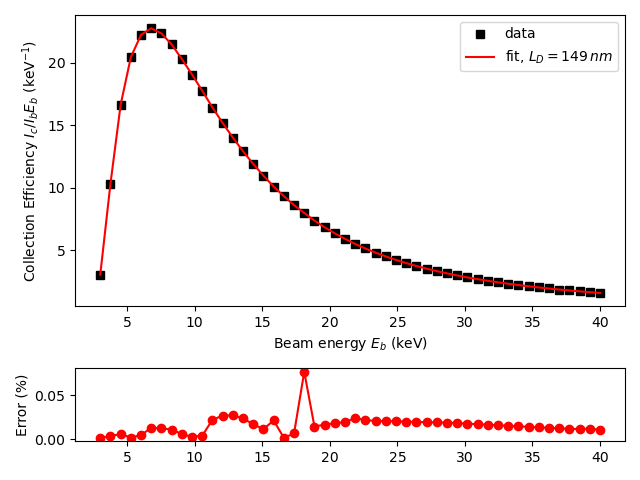

In [5]:
data = []
path = 'data/synthetic.csv' # tm = 40nm, W = 500nm, L = 150nm, G0 = 1
E, I_data, I_fit, params = fit_data(path = path, tm = 50, W = 500)
data.append([E, I_data, I_fit, params, path])

Metal thickness : 41.02 nm ± 1.57 nm
 SCR width : 577.74 nm ± 750.93 nm
 Diffusion length : 138.92 ± 30.00 nm
 η/Ei : 0.91 ± 4.12 eV-1
-----------------------------------------
Elapsed time: 8.23 s


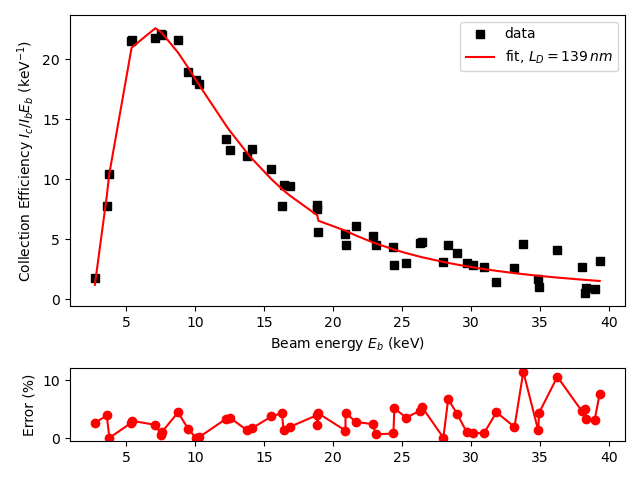

In [6]:
data = []
path = 'data/synthetic_noise.csv' # tm = 40nm, W = 500nm, L = 150nm, G0 = 1
E, I_data, I_fit, params = fit_data(path = path, tm = 50, W = 500)
data.append([E, I_data, I_fit, params, path])

# Plot real data
### S1 data fitting

Metal thickness : 42.66 nm ± 4.29 nm
 SCR width : 591.29 nm ± 1575.56 nm
 Diffusion length : 147.01 ± 68.25 nm
 η/Ei : 0.98 ± 8.68 eV-1
-----------------------------------------
Elapsed time: 7.23 s


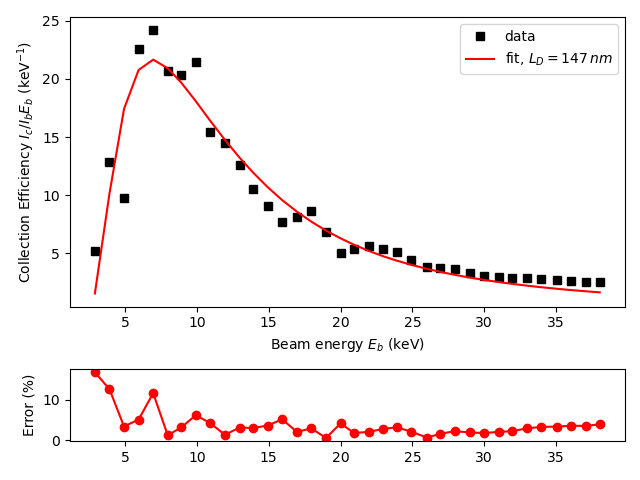

In [7]:
data = []
path = 'data/S1.csv'
E, I_data, I_fit, params = fit_data(path = path, tm = 40, W = 600)
data.append([E, I_data, I_fit, params, path])

### S3 data fitting

Metal thickness : 165.54 nm ± 4.89 nm
 SCR width : 1800.46 nm ± 555.29 nm
 Diffusion length : 556.86 ± 0.00 nm
 η/Ei : 0.82 ± 0.74 eV-1
-----------------------------------------
Elapsed time: 5.14 s


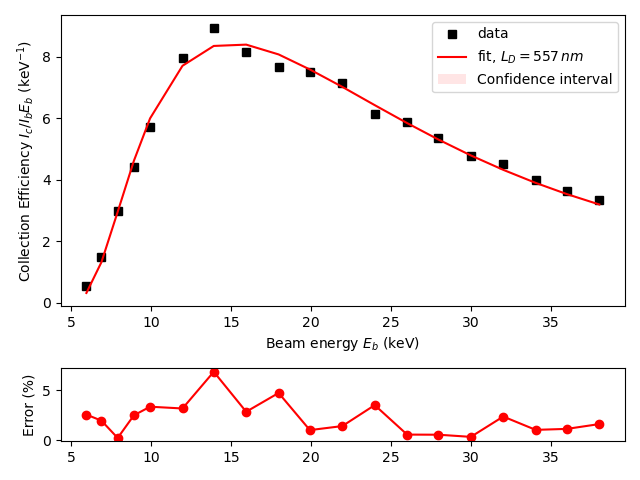

In [8]:
path = 'data/S3.csv'
E, I_data, I_fit, params = fit_data(path = path, tm = 80, W = 500, error = True)
data.append([E, I_data, I_fit, params, path])

### S2 data fitting

Metal thickness : 28.79 nm ± 0.75 nm
 SCR width : 378.57 nm ± 220.57 nm
 Diffusion length : 105.65 ± 10.36 nm
 η/Ei : 0.88 ± 1.52 eV-1
-----------------------------------------
Elapsed time: 3.64 s


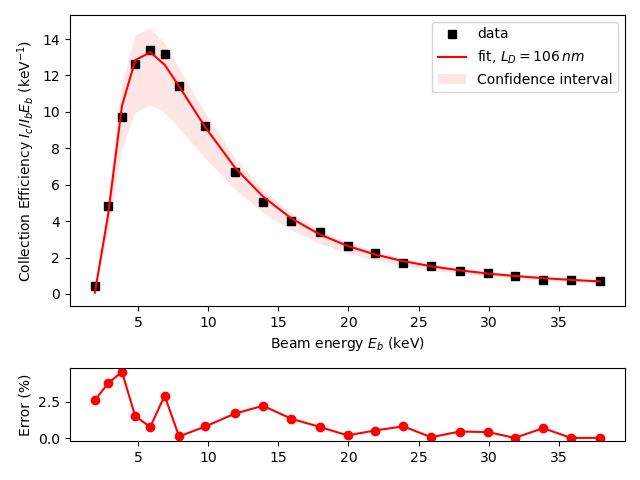

In [9]:
path = 'data/S2.csv'
E, I_data, I_fit, params = fit_data(path = path, tm = 40, W = 500, error = True)
data.append([E, I_data, I_fit, params, path])

### S4 data Fitting

Metal thickness : 12.32 nm ± 2.48 nm
 SCR width : 1212.06 nm ± 1255.69 nm
 Diffusion length : 487.34 ± 0.00 nm
 η/Ei : 0.53 ± 1.23 eV-1
-----------------------------------------
Elapsed time: 6.96 s


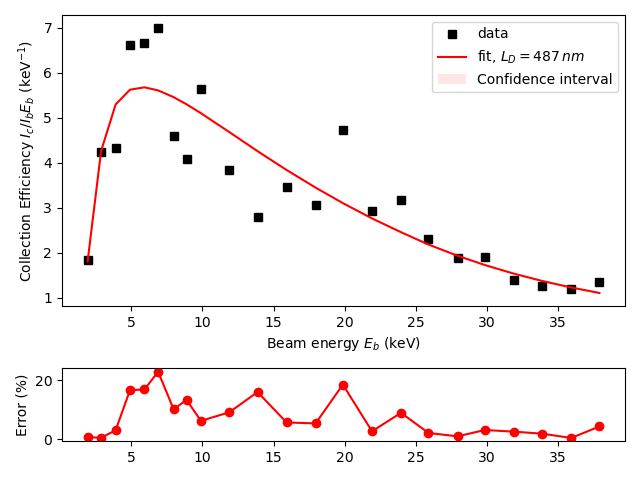

In [10]:
path = 'data/S4.csv'
E, I_data, I_fit, params = fit_data(path = path, tm = 40, W = 500, error = True)
data.append([E, I_data, I_fit, params, path])

### Alpha

Metal thickness : 38.64 nm ± 2.66 nm
 SCR width : 519.87 nm ± 492.47 nm
 Diffusion length : 151.65 ± 23.04 nm
 η/Ei : 2.77 ± 7.48 eV-1
-----------------------------------------
Elapsed time: 5.42 s


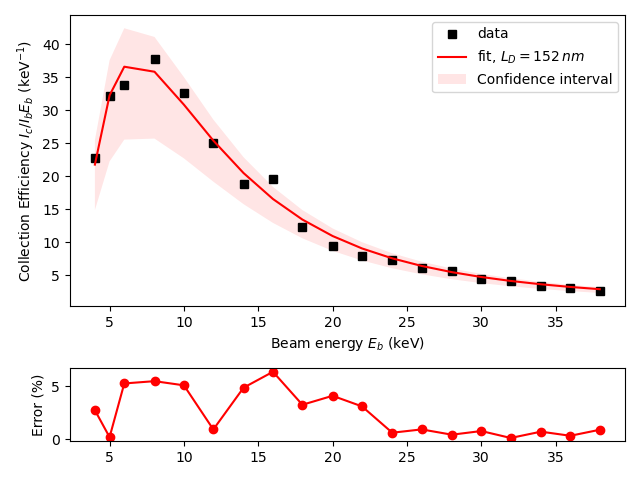

In [11]:
path = 'data/alpha.csv'
E, I_data, I_fit, params = fit_data(path = path, tm = 40, W = 500, error = True)
data.append([E, I_data, I_fit, params, path])